### Requirements

In [64]:
import pandas as pd
import numpy as np
import bz2
import json
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import requests
import findspark

### Objectives M2
- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

### Test with PySpark
https://spark.apache.org/docs/latest/sql-programming-guide.html

In [3]:
# Create a spark context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Read JSON file into dataframe
df = spark.read.json('data/quotes-2020.json.bz2')

In [ ]:
df.show()

## A .Understanding of what’s in the data (formats, distributions, missing values, correlations, etc.).

### A1. Formats of the data

#### Summary Columns
- **quoteID**:      Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
- **quotation**:    Text of the longest encountered original form of the quotation
- **speaker**:      Selected most likely speaker
- **qids**:         Wikidata IDs of all aliases that match the selected speaker
- **date**:         Earliest occurrence date of any version of the quotation
- **numOccurences**:Number of time this quotation occurs in the articles
- **probas**:       Array representing the probabilities of each speaker having uttered the quotation
- **urls**:         List of links to the original articles containing the quotation
- **phase**:        Corresponding phase of the data in which the quotation first occurred (A-E)
- **domains**:      Domain of the URL 

In [ ]:
df.printSchema()

An interesting view to have is the overall distribution of speakers, and which are the most represented, by counting thier number of occurences.

We want to analyse whether there are errors in the columns, that would show if a null value would appear in one of the columns. Thus, we check each column for such an error. However, we do not check the Speakers column, it is natural to find None values, occuring when Quootstrap did not find an appropriate speaker for the quote

In [ ]:
df.filter(df.date == None).show()
df.filter(df.numOccurrences == None).show()
df.filter(df.phase == None).show()
df.filter(df.probas == None).show()
df.filter(df.qids == None).show()
df.filter(df.quotation == None).show()
df.filter(df.quoteID == None).show()
df.filter(df.speaker == None).show()
df.filter(df.urls == None).show()

However, a way to check the integrity of the speakers is to compare the attributed speaker to the one with the highest probability as indicated in the probas column. In the meantime, we compare the ditribution of the overall speakers 

In [29]:
temp = df.select(df.speaker, df.probas)
temp = temp.withColumn("highest_prob", temp.probas[0])
temp = temp.withColumn("prob_speaker", temp.highest_prob[0])

error_speakers = temp.filter(temp.speaker != temp.prob_speaker)
error_speakers.show(30)

+-----------------+--------------------+--------------------+--------------------+
|          speaker|              probas|        highest_prob|        prob_speaker|
+-----------------+--------------------+--------------------+--------------------+
|             None|[[Kris Bryant, 0....|[Kris Bryant, 0.4...|         Kris Bryant|
|         Jane Roe|[[None, 0.2695], ...|      [None, 0.2695]|                None|
| Christian Doidge|[[None, 0.1002], ...|      [None, 0.1002]|                None|
|     Heidi Larson|[[None, 0.0614], ...|      [None, 0.0614]|                None|
|             None|[[Rio Ferdinand, ...|[Rio Ferdinand, 0...|       Rio Ferdinand|
|             None|[[Paul Brown, 0.3...|[Paul Brown, 0.3887]|          Paul Brown|
|     Joel Dommett|[[None, 0.0367], ...|      [None, 0.0367]|                None|
|        Ed Turner|[[None, 0.0172], ...|      [None, 0.0172]|                None|
|      Peter Weber|[[None, 0.3477], ...|      [None, 0.3477]|                None|
|   

In [31]:
WrongSpeakers = error_speakers.groupBy("prob_speaker").count()
asc_wrong = WrongSpeakers.sort("count", ascending = False)

overall_speakers = temp.groupBy("prob_speaker").count()
asc_overall = overall_speakers.sort("count", ascending = False)

In [87]:
import matplotlib.pyplot as plt

overall = asc_overall.toPandas()
wrong = asc_wrong.toPandas()

Text(0.5, 1.0, 'Distribution of the most cited people in the dataset')

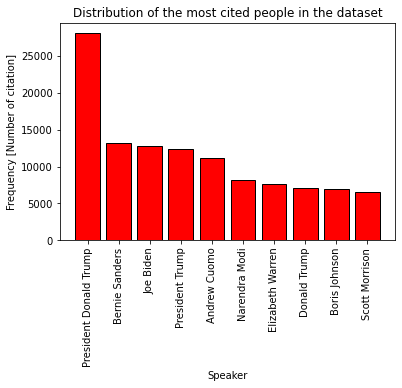

In [88]:
overall = overall[1:11]

fig = plt.figure()
plt.bar(overall["prob_speaker"], overall["count"], color = 'r', ec='black')
plt.xlabel('Speaker')
plt.xticks(rotation = "vertical")
plt.ylabel('Frequency [Number of citation]')
plt.title('Distribution of the most cited people in the dataset overall')

Text(0.5, 1.0, 'Distribution of the most cited people in the dataset in misatributed speakers ')

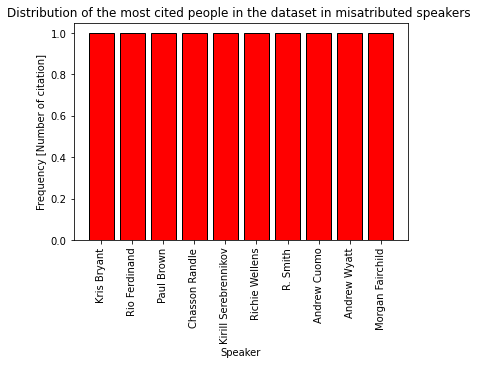

In [89]:
wrong = wrong[1:11]

fig = plt.figure()
plt.bar(wrong["prob_speaker"], wrong["count"], color = 'r', ec='black')
plt.xlabel('Speaker')
plt.xticks(rotation = "vertical")
plt.ylabel('Frequency [Number of citation]')
plt.title('Distribution of the most cited people in the dataset in misatributed speakers ')

As we can expect, the most cited speakers are ones that are the most talked about depending on the events of the year. In the 2020 dataset, we find the quotes relating to the american elections, and we see that the most cited speakers are almost all the ones more or less related to them, exept for Narendra Modi, most likely appearing because of the global unrest in india during 2020.
As far as the "misslabeled" datapoints, we do not see any specific pattern. Every speaker that is misslabeled is so only once



### A2. Distributions
- Idea: Distribution of the words ? Or maybe later ?

### A3. Missing Values

### A4. Correlation
- Idea: slides du cours ? Je ne sais pas si on doit déjà commencer à faire ce genre d'analyse

## Ways to enrich, filter, transform the data.

To simplify the tasks, we will use a specific event that will allow us to compute faster and try our methods. We take 

In [11]:
df_australia = df.filter(df.quotation.contains('Parasite')).limit(2400)
df_australia.show()

australia = df_australia.toPandas()
australia_words = australia.iloc[:,5]

splitted = []

for sub in australia_words:
    for wrd in sub.split():
        splitted.append(wrd)

+-------------------+--------------+-----+--------------------+--------------------+--------------------+-----------------+--------------+--------------------+
|               date|numOccurrences|phase|              probas|                qids|           quotation|          quoteID|       speaker|                urls|
+-------------------+--------------+-----+--------------------+--------------------+--------------------+-----------------+--------------+--------------------+
|2020-03-27 14:32:11|             1|    E|[[None, 0.8727], ...|                  []|If you think that...|2020-03-27-025761|          None|[https://www.mirr...|
|2020-02-10 18:54:16|             1|    E|[[None, 0.8968], ...|                  []|The good news for...|2020-02-10-074480|          None|[https://www.holl...|
|2020-02-11 05:00:00|             5|    E|[[None, 0.6152], ...|                  []|Bong Joon-ho's `P...|2020-02-11-011012|          None|[http://www.wsws....|
|2020-03-02 00:04:49|             1|    

At the level of Quotes, since we want to capture the essence of the words, we need to filter a bit the data. First, we will need to get rid of the "common" words that do not contribute much to the actual meaning of the sentence and have a risk of overshadowing the relevant information. 

In [ ]:
from collections import Counter

counter_aust = Counter(temp)
most_occur = counter_aust.most_common(100)
  
print(most_occur)

We see that indeed, even in this small subset, we have predominant nonimportant words. To then extract relevant words, we can use the TF-IDF method, which is an information retrieval technique that produces a value that increases depending on how many time it is cited in a document, but also decreases the more it is present in different documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_sentence)

vectorizer.get_feature_names()

We see that we have some interesting information, but still have quite a large amount of words. We might need to filter accoring to specific criteria to direct the search

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in splitted if not w.lower() in stop_words]
print("There are in the unfiltered subset:",len(splitted), "words")
print("There are in the filtered subset:", len(filtered_sentence), "words")

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

pos_quotes = []
neg_quotes = []

for i in range(0, len(australia_words)):
    
    humor = sia.polarity_scores(australia_words[i])
    if humor["pos"] > 0.4:
        pos_quotes.append(australia_words[i])
    elif humor["neg"] > 0.4:
        neg_quotes.append(australia_words[i])

print("The mostly positive quotes are:", pos_quotes)
print("The mostly negative quotes are:", neg_quotes)

### B1. Task
- Quotes: need to use different functions in order filter the quotes before analyzing
    - remove stop words (and, the, ...)
    - stemming and lemming the quotes
    - use NLTK function in order to categorize the words in the sentence for example
- Speakers: 
    - need to keep only the speakers different form "None"
        - is it resonnable tp drop the None speakers ? Not a too big percentage of the dataset ? 
    - need to regroup speakers like "President Donald Trump" and "Donald Trump"
    - add columns with the occupations/jobs of the speakers maybe in a new column (Obama : politician,lawyer,author)
- QIDS:  
    - add the link to the wikipedia page of the speaker
    - keep only the qids of the speaker
        - need to check if everything OK with the qids (qids speaker =?= speaker)
- Date:
    - Try to keep only the important informations about the date (maybe don't need to keep the minutes)
- Removes columns that we do not need (quotesID, phase, ...?)

A popular method to extract relevance of words in a corpus is TF-IDF. This method 

A useful tool is the Natural Language ToolKit, which implemented various functions destined to process language, which we can take advantage of. For example, we need to filter common words such as coordinations that blur the processing 

We see that though it is quite basic, it gives a good idea of the feeling of certain quotes. Given that it is possible to "improve" VADER, for example depending on the events we can find new words associated with negative and positive emotions, to help it recognize the sentences in this context.

## Analysis 

- quids same for each quote 
- check proba avec le speaker 
- check chaque colonne
- verifier l'URL 

**Analysing Selected Speaker vs Highest Probablity Speaker**

Comparing the speaker in the "speaker" column against the one with the highest probability in "probas", outputing the lines with different values for those two, and counting the number of occurences, displaying the highest ones

**Analysing Columns**

Checking for aberrent values in the dataset, each column separately

In [ ]:
# speaker
df_speakers =df.drop_duplicates(subset=['speaker'])

In [ ]:
num_diff_speakers = df_speakers.count()

In [ ]:
df_names = df_speakers[['speaker']]

In [ ]:
df_none = df[df.speaker=='None']

# Note - problem with this cell : Can't extract value from speaker#14: need struct type but got string
df[df['speaker'].str.contains('pokemon')]

In [ ]:
df_test = pd.DataFrame(df.head(100), columns=df.columns)
df.filter(df_test.speaker.contains('google.com')).show()

### Cell to take only the speakers ('at' because append between different datasets (years))

In [120]:
path_to_file = 'data/quotes-2019.json.bz2' 
path_to_out = 'data/speakers_19_20.txt.bz2'
k =0
with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'at') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            speaker = instance['speaker'] # takes only speakers names
            d_file.write(speaker+'\n')# writing in the new file

**Analysing Number of Occurences**

Looking at the most occuring Quotes

In [ ]:
ordered_occurences = df.sort("numOccurrences", ascending = False).show()

#### Analysis on speakers 
- Number of different speakers : 218415

In [122]:
data = pd.read_csv('data/speakers_19_20.txt.bz2', sep="\n", header=None)
data = data[data[0] !='None'].drop_duplicates()

### Special cases in the speaker's name

In [124]:
df_trump = data.loc[data[0].str.contains('Trump',case = False)]
df_trump = df_trump.drop_duplicates()
searchfor = ['Melania', 'Eric','Ivanka','judd','trumpauer','Barron','Lara','Andreas','william','trumper','spencer','blaine','charles','ivana']
df_trump = df_trump[~df_trump[0].str.contains('|'.join(searchfor),case = False)]
df_trump

,0
247,Donald Trump
263,President Donald Trump
609,President Trump
13688,Donald Trump Jr. .
15578,Donald Trump Jr
16328,"Donald Trump , Jr. ."
16448,Donald J. Trump
27659,President Donald J. Trump
31087,Donald trump
38768,president Donald Trump


- There are more than 35 different names for Donald Trump, in lower and upper cases

In [129]:
data['len'] = data[0].apply(lambda x : len(x.split()))
data[data['len'] >= 9]

,0,len
6766815,"Cristóbal Colón de Carvajal y Gorosábel , 18th...",11
12115980,"David Albert Charles Armstrong-Jones , 2nd Ear...",9
14789104,"Julian Asquith , 2nd Earl of Oxford and Asquith",9
15931964,eating disorders working group of the Psychiat...,9
17341178,"Christopher Walter Monckton , 3rd Viscount Mon...",9
23036249,Eating Disorders Working Group of the Psychiat...,9


In [133]:
df_duchess = data.loc[data[0].str.contains('Duchess',case = False)].drop_duplicates()
df_duchess.head(5)

,0,len
3017,"Meghan , the Duchess of Sussex",6
4166,"Camilla , Duchess of Cornwall",5
7622,Duchess of Sussex,3
9489,"Meghan , Duchess of Sussex",5
18938,Duchess Meghan,2


- same problem with the words: Duchess, Minister, Professor, 

In [134]:
df_director = data[data[0].str.contains('director',case = False)].drop_duplicates()
df_director.head(5)

,0,len
7259,theater director,2
290334,Director X,2
875877,Theater Director,2
1278777,Theater director,2
3334797,director x,2


- same problem with the word director but when thinking about it, it's not really a name 

In [136]:
df_speacial_cases = data.loc[data[0].str.contains("''",case = False)].drop_duplicates()
df_speacial_cases

,0,len
16887,Philip `` Brave '' Davis,5
18367,Nicole `` Snooki '' Polizzi,5
28771,Steve `` Lips '' Kudlow,5
30179,Kent `` Smallzy '' Small,5
50412,Jake `` The Snake '' Roberts,6
...,...,...
25099511,Walter `` Wali '' Jones,5
25123980,Leticia `` Tish '' Cyrus,5
25204213,Vincent `` Rocco '' Vargas,5
25857515,Nancy `` Rusty '' Barceló,5


- some speakers name contain "'"

In [137]:
data[data[0] == "Hey That 's No Way to Say Goodbye"]

,0,len
1945236,Hey That 's No Way to Say Goodbye,8


- speakers with strange name 